In [9]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
spark_version = 'spark-3.5.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark


# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [10]:
#Import dependencies
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from google.colab import drive
drive.mount('/content/drive')

# Import Keras Dependencies
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, LeakyReLU, PReLU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
 # Import findspark and initialize.
import findspark
findspark.init()

In [12]:
 # Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("weatherclassification").getOrCreate()

In [13]:
# Load in data
from pyspark import SparkFiles
url = 'https://weatherclassification.s3.amazonaws.com/weather_classification_data.csv'
spark.sparkContext.addFile(url)
print(SparkFiles.getRootDirectory())

spark_df = spark.read.csv(SparkFiles.get("weather_classification_data.csv"), sep=",", header=True, inferSchema=True)
spark_df.show()

/tmp/spark-adc87690-704f-4a03-ad74-edb948c1e08e/userFiles-660b4147-fd7f-48c5-b63d-7a0f44ee1cac
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|Temperature|Humidity|Wind Speed|Precipitation (%)|  Cloud Cover|Atmospheric Pressure|UV Index|Season|Visibility (km)|Location|Weather Type|
+-----------+--------+----------+-----------------+-------------+--------------------+--------+------+---------------+--------+------------+
|         14|      73|       9.5|               82|partly cloudy|             1010.82|       2|Winter|            3.5|  inland|       Rainy|
|         39|      96|       8.5|               71|partly cloudy|             1011.43|       7|Spring|           10.0|  inland|      Cloudy|
|         30|      64|       7.0|               16|        clear|             1018.72|       5|Spring|            5.5|mountain|       Sunny|
|         38|      83|       1.5|               82|        

In [14]:
# Convert PySpark DataFrame to pandas DataFrame
weather_df = spark_df.toPandas()
weather_df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14,73,9.5,82,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39,96,8.5,71,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30,64,7.0,16,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38,83,1.5,82,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27,74,17.0,66,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [15]:
# Check for missing values
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  int32  
 1   Humidity              13200 non-null  int32  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  int32  
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int32  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(3), int32(4), object(4)
memory usage: 928.2+ KB


In [16]:
# Determine number of unique weather types
weather_df['Weather Type'].unique()

array(['Rainy', 'Cloudy', 'Sunny', 'Snowy'], dtype=object)

In [18]:
# Determine each weather type value counts
print(weather_df['Weather Type'].value_counts())
print(weather_df['Season'].value_counts())

Weather Type
Rainy     3300
Cloudy    3300
Sunny     3300
Snowy     3300
Name: count, dtype: int64
Season
Winter    5610
Spring    2598
Autumn    2500
Summer    2492
Name: count, dtype: int64


In [19]:
#Remove weather type
weather_data_no_type = weather_df.drop('Weather Type', axis=1)

In [20]:
# Convert categorical data to numeric with 'get_dummies'
weather_data_no_type = pd.get_dummies(weather_data_no_type).astype(int)
weather_data_no_type.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,14,73,9,82,1010,2,3,0,0,0,1,0,0,0,1,0,1,0
1,39,96,8,71,1011,7,10,0,0,0,1,0,1,0,0,0,1,0
2,30,64,7,16,1018,5,5,1,0,0,0,0,1,0,0,0,0,1
3,38,83,1,82,1026,7,1,1,0,0,0,0,1,0,0,1,0,0
4,27,74,17,66,990,1,2,0,0,1,0,0,0,0,1,0,0,1


In [21]:
# Split preprocessed data into features and target arrays
X = weather_data_no_type
y = weather_df['Weather Type']

# Use LabelEncoder to convert categorical weather type labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = 4
y_one_hot = to_categorical(y_encoded, num_classes)

encoded_labels = label_encoder.classes_
encoded_labels = label_encoder.transform(label_encoder.classes_)
label_mapping = dict(zip(encoded_labels, label_encoder.classes_))
print(f"Labels: {label_mapping}")

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, random_state=1)

Labels: {0: 'Cloudy', 1: 'Rainy', 2: 'Snowy', 3: 'Sunny'}


In [22]:
# Determine Data Shape
print('Data Shapes')
print(f'Training Data: {X_train.shape}')
print(f'Training Labels: {y_train.shape}')
print(f'Testing Data: {X_test.shape}')
print(f'Testing Labels: {y_test.shape}')

Data Shapes
Training Data: (9900, 18)
Training Labels: (9900, 4)
Testing Data: (3300, 18)
Testing Labels: (3300, 4)


In [ ]:
# Normalize Data
scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Create function for model creation
def gen_model(units, activation_functions, input_dim, optimizer):
  # Define the deep learning model
  nn_model = tf.keras.models.Sequential()
  nn_model.add(tf.keras.Input(shape=(input_dim,)))
  for i in range(len(units)):
    nn_model.add(tf.keras.layers.Dense(units=units[i], activation=activation_functions[i]))
  nn_model.add(tf.keras.layers.Dense(units=4, activation="softmax"))

  # Compile the Sequential model together and customize metrics
  nn_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return nn_model

In [ ]:
# Model Optimizer Adam
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_adam = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_adam.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_adam.evaluate(X_test,y_test,verbose=2)

print(f"Model Optimizer Adam Loss: {model_loss}, Accuracy: {model_accuracy}")


Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5430 - loss: 1.1145 - val_accuracy: 0.8146 - val_loss: 0.5671
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8393 - loss: 0.5150 - val_accuracy: 0.8793 - val_loss: 0.4228
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8725 - loss: 0.4245 - val_accuracy: 0.8823 - val_loss: 0.3787
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8823 - loss: 0.3669 - val_accuracy: 0.8889 - val_loss: 0.3455
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8780 - loss: 0.3552 - val_accuracy: 0.8894 - val_loss: 0.3308
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8966 - loss: 0.3173 - val_accuracy: 0.8919 - val_loss: 0.3246
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8971 - loss: 0.3071 - val_accuracy: 0.8924 - val_loss: 0.2992
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9027 - loss: 0.2881 - val_accuracy: 0.

In [ ]:
# Make predictions using testing data
predictions = nn_model_adam.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer Adam')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer Adam ")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Optimizer Adam
[[734  59  27  22]
 [ 34 757  29  26]
 [ 14  17 771  18]
 [ 40  17  21 714]]
Classification Report Model Optimizer Adam 
              precision    recall  f1-score   support

      Cloudy       0.89      0.87      0.88       842
       Rainy       0.89      0.89      0.89       846
       Snowy       0.91      0.94      0.92       820
       Sunny       0.92      0.90      0.91       792

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [ ]:
# Get training and validation loss and accuracy values
nn_model_adam_losses = fit_model.history['loss']
nn_model_adam_accuracy = fit_model.history['accuracy']
nn_model_adam_val_losses = fit_model.history['val_loss']
nn_model_adam_val_accuracy = fit_model.history['val_accuracy']

In [ ]:
# Model Optimizer SDG
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_SDG = gen_model(units, activations_funcs, 18, 'SGD')


# Train the model
fit_model = nn_model_SDG.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_SDG.evaluate(X_test,y_test,verbose=2)
print(f"Model Optimizer SDG Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2876 - loss: 1.3827 - val_accuracy: 0.4374 - val_loss: 1.3476
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4368 - loss: 1.3375 - val_accuracy: 0.5530 - val_loss: 1.2855
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6093 - loss: 1.2384 - val_accuracy: 0.7035 - val_loss: 1.0047
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7182 - loss: 0.9118 - val_accuracy: 0.7980 - val_loss: 0.6848
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8031 - loss: 0.6645 - val_accuracy: 0.8328 - val_loss: 0.5723
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8235 - loss: 0.5818 - val_accuracy: 0.8449 - val_loss: 0.5124
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8367 - loss: 0.5188 - val_accuracy: 0.8586 - val_loss: 0.4708
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8476 - loss: 0.4916 - val_accuracy: 0.

In [ ]:
# Make predictions using testing data
predictions = nn_model_SDG.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer SDG')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer SDG")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Optimizer SDG
[[747  54  19  22]
 [ 46 749  25  26]
 [ 18  21 764  17]
 [ 36  19  18 719]]
Classification Report Model Optimizer SDG
              precision    recall  f1-score   support

      Cloudy       0.88      0.89      0.88       842
       Rainy       0.89      0.89      0.89       846
       Snowy       0.92      0.93      0.93       820
       Sunny       0.92      0.91      0.91       792

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [ ]:
# Get training and validation loss and accuracy values
nn_model_SDG_losses = fit_model.history['loss']
nn_model_SDG_accuracy = fit_model.history['accuracy']
nn_model_SDG_val_losses = fit_model.history['val_loss']
nn_model_SDG_val_accuracy = fit_model.history['val_accuracy']

In [ ]:
# Model Optimizer Adagrad
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_adagrad = gen_model(units, activations_funcs, 18, 'Adagrad')


# Train the model
fit_model = nn_model_adagrad.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_adagrad.evaluate(X_test,y_test,verbose=2)
print(f"Model Optimizer Adagrad Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3418 - loss: 1.3718 - val_accuracy: 0.4525 - val_loss: 1.3429
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4685 - loss: 1.3347 - val_accuracy: 0.4939 - val_loss: 1.3054
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4943 - loss: 1.3008 - val_accuracy: 0.5217 - val_loss: 1.2689
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5322 - loss: 1.2639 - val_accuracy: 0.5242 - val_loss: 1.2347
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5351 - loss: 1.2326 - val_accuracy: 0.5323 - val_loss: 1.2022
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5465 - loss: 1.1929 - val_accuracy: 0.5197 - val_loss: 1.1718
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5346 - loss: 1.1677 - val_accuracy: 0.5182 - val_loss: 1.1427
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5196 - loss: 1.1436 - val_accuracy: 0.

In [ ]:
# Make predictions using testing data
predictions = nn_model_adagrad.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer Adagrad')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer Adagrad")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix Model Optimizer Adagrad
[[675 139  13  15]
 [138 532 161  15]
 [ 38  23 750   9]
 [ 89  22   4 677]]
Classification Report Model Optimizer Adagrad
              precision    recall  f1-score   support

      Cloudy       0.72      0.80      0.76       842
       Rainy       0.74      0.63      0.68       846
       Snowy       0.81      0.91      0.86       820
       Sunny       0.95      0.85      0.90       792

    accuracy                           0.80      3300
   macro avg       0.80      0.80      0.80      3300
weighted avg       0.80      0.80      0.80      3300



In [ ]:
# Get training and validation loss and accuracy values
nn_model_adagrad_losses = fit_model.history['loss']
nn_model_adagrad_accuracy = fit_model.history['accuracy']
nn_model_adagrad_val_losses = fit_model.history['val_loss']
nn_model_adagrad_val_accuracy = fit_model.history['val_accuracy']

In [ ]:
# Model Optimizer RMSProp
units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_RMSprop = gen_model(units, activations_funcs, 18, 'RMSProp')


# Train the model
fit_model = nn_model_RMSprop.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_RMSprop.evaluate(X_test,y_test,verbose=2)
print(f"Model Optimizer RMSProp Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4908 - loss: 1.1229 - val_accuracy: 0.8379 - val_loss: 0.6070
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8384 - loss: 0.5562 - val_accuracy: 0.8707 - val_loss: 0.4280
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8639 - loss: 0.4293 - val_accuracy: 0.8864 - val_loss: 0.3551
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8817 - loss: 0.3506 - val_accuracy: 0.8808 - val_loss: 0.3316
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8811 - loss: 0.3399 - val_accuracy: 0.8884 - val_loss: 0.3066
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8870 - loss: 0.3084 - val_accuracy: 0.8894 - val_loss: 0.2856
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8858 - loss: 0.3038 - val_accuracy: 0.8949 - val_loss: 0.2760
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8958 - loss: 0.2864 - val_accuracy: 0.

In [ ]:
# Make predictions using testing data
predictions = nn_model_RMSprop.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Optimizer RMSProp')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Optimizer RMSProp")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Optimizer RMSProp
[[769  30  18  25]
 [ 62 729  30  25]
 [ 22   8 768  22]
 [ 50  11  15 716]]
Classification Report Model Optimizer RMSProp
              precision    recall  f1-score   support

      Cloudy       0.85      0.91      0.88       842
       Rainy       0.94      0.86      0.90       846
       Snowy       0.92      0.94      0.93       820
       Sunny       0.91      0.90      0.91       792

    accuracy                           0.90      3300
   macro avg       0.91      0.90      0.90      3300
weighted avg       0.91      0.90      0.90      3300



In [ ]:
# Get training and validation loss and accuracy values
nn_model_RMSprop_losses = fit_model.history['loss']
nn_model_RMSprop_accuracy = fit_model.history['accuracy']
nn_model_RMSprop_val_losses = fit_model.history['val_loss']
nn_model_RMSprop_val_accuracy = fit_model.history['val_accuracy']

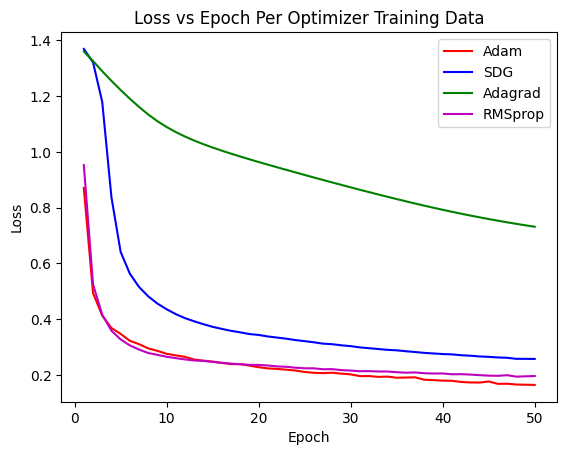

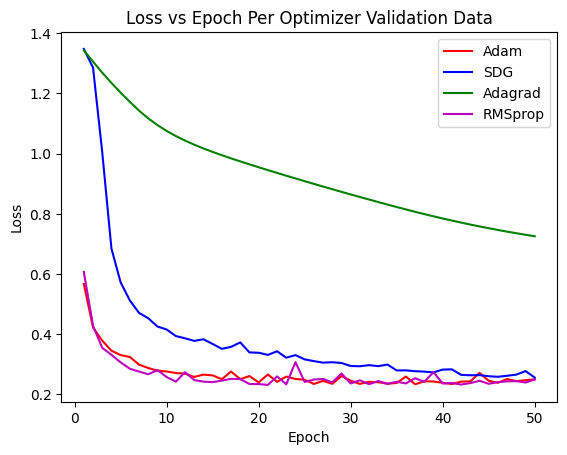

In [ ]:
# Plot losses for each optimizer training data

epochs = range(1, len(nn_model_adam_losses) + 1)

plt.plot(epochs, nn_model_adam_losses, 'r', label = 'Adam')
plt.plot(epochs, nn_model_SDG_losses, 'b', label = 'SDG')
plt.plot(epochs, nn_model_adagrad_losses, 'g', label = 'Adagrad')
plt.plot(epochs, nn_model_RMSprop_losses, 'm', label = 'RMSprop')

plt.title('Loss vs Epoch Per Optimizer Training Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Optimizer Training Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Optimizer Training Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Optimizer Training Data.png', format='png')

plt.show()



# Plot losses for each optimizer validation data

epochs = range(1, len(nn_model_adam_losses) + 1)

plt.plot(epochs, nn_model_adam_val_losses, 'r', label = 'Adam')
plt.plot(epochs, nn_model_SDG_val_losses, 'b', label = 'SDG')
plt.plot(epochs, nn_model_adagrad_val_losses, 'g', label = 'Adagrad')
plt.plot(epochs, nn_model_RMSprop_val_losses, 'm', label = 'RMSprop')

plt.title('Loss vs Epoch Per Optimizer Validation Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Optimizer Validation Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Optimizer Validation Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Optimizer Validation Data.png', format='png')

plt.show()



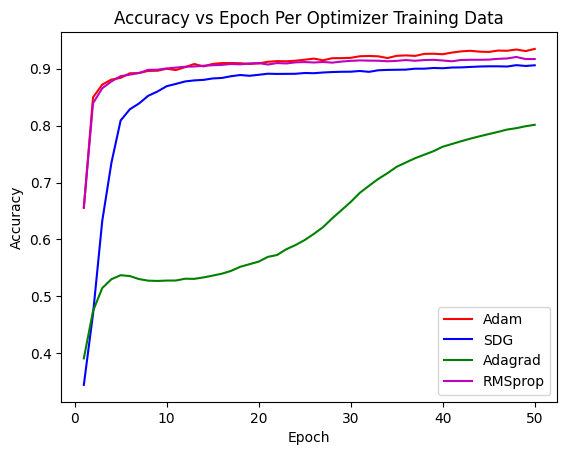

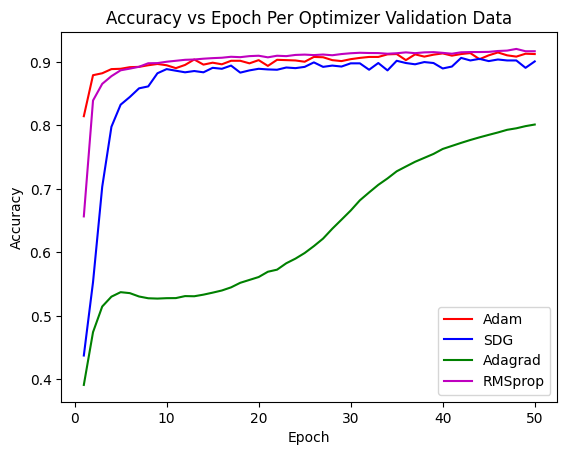

In [ ]:
# Plot accuracy for each optimizer training data

epochs = range(1, len(nn_model_adam_accuracy) + 1)

plt.plot(epochs, nn_model_adam_accuracy, 'r', label = 'Adam')
plt.plot(epochs, nn_model_SDG_accuracy, 'b', label = 'SDG')
plt.plot(epochs, nn_model_adagrad_accuracy, 'g', label = 'Adagrad')
plt.plot(epochs, nn_model_RMSprop_accuracy, 'm', label = 'RMSprop')

plt.title('Accuracy vs Epoch Per Optimizer Training Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Optimizer Training Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Optimizer Training Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Optimizer Training Data.png', format='png')

plt.show()



# Plot accuracy for each optimizer validation data

epochs = range(1, len(nn_model_adam_losses) + 1)

plt.plot(epochs, nn_model_adam_val_accuracy, 'r', label = 'Adam')
plt.plot(epochs, nn_model_SDG_val_accuracy, 'b', label = 'SDG')
plt.plot(epochs, nn_model_adagrad_accuracy, 'g', label = 'Adagrad')
plt.plot(epochs, nn_model_RMSprop_accuracy, 'm', label = 'RMSprop')

plt.title('Accuracy vs Epoch Per Optimizer Validation Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Optimizer Validation Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Optimizer Validation Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Optimizer Validation Data.png', format='png')

plt.show()



In [ ]:
# Model Activation Relu
units = units = [64, 32, 16, 8]
activations_funcs = ['relu', 'relu', 'relu', 'relu']
nn_model_relu = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_relu.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_relu.evaluate(X_test,y_test,verbose=2)

print(f"Model Activation ReLU Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6021 - loss: 1.0208 - val_accuracy: 0.8530 - val_loss: 0.4523
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8597 - loss: 0.4441 - val_accuracy: 0.8788 - val_loss: 0.3649
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8838 - loss: 0.3533 - val_accuracy: 0.8889 - val_loss: 0.3238
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8895 - loss: 0.3140 - val_accuracy: 0.8859 - val_loss: 0.3071
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8925 - loss: 0.3070 - val_accuracy: 0.9015 - val_loss: 0.2865
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8910 - loss: 0.2999 - val_accuracy: 0.8939 - val_loss: 0.2744
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9056 - loss: 0.2735 - val_accuracy: 0.8995 - val_loss: 0.2661
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9009 - loss: 0.2764 - val_accuracy: 0.

In [ ]:
# Make predictions using testing data
predictions = nn_model_relu.predict(X_test)

# Convert one-hot encoded values to categorical labes
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Activation ReLU')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Activation ReLU")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Activation ReLU
[[750  40  40  12]
 [ 52 740  53   1]
 [ 14  20 780   6]
 [ 33  20  35 704]]
Classification Report Model Activation ReLU
              precision    recall  f1-score   support

      Cloudy       0.88      0.89      0.89       842
       Rainy       0.90      0.87      0.89       846
       Snowy       0.86      0.95      0.90       820
       Sunny       0.97      0.89      0.93       792

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [ ]:
# Get training and validation loss and accuracy values
nn_model_relu_losses = fit_model.history['loss']
nn_model_relu_accuracy = fit_model.history['accuracy']
nn_model_relu_val_losses = fit_model.history['val_loss']
nn_model_relu_val_accuracy = fit_model.history['val_accuracy']

In [ ]:
# Model Activation LeakyReLU
units = [64, 32, 16, 8]
activations_funcs = [LeakyReLU(alpha=0.01), LeakyReLU(alpha=0.01), LeakyReLU(alpha=0.01), LeakyReLU(alpha=0.01)]
nn_model_leakyrelu = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_leakyrelu.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_leakyrelu.evaluate(X_test,y_test,verbose=2)

print(f"Model Activation LeakyReLU Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5269 - loss: 1.0737 - val_accuracy: 0.8247 - val_loss: 0.5420
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8404 - loss: 0.5161 - val_accuracy: 0.8682 - val_loss: 0.4249
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8704 - loss: 0.4163 - val_accuracy: 0.8793 - val_loss: 0.3833
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8796 - loss: 0.3777 - val_accuracy: 0.8884 - val_loss: 0.3462
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8859 - loss: 0.3474 - val_accuracy: 0.8970 - val_loss: 0.3241
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8930 - loss: 0.3070 - val_accuracy: 0.8955 - val_loss: 0.2983
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8890 - loss: 0.3146 - val_accuracy: 0.8960 - val_loss: 0.2824
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8977 - loss: 0.2933 - val_accuracy: 0.8934 - val_

In [ ]:
# Make predictions using testing data
predictions = nn_model_leakyrelu.predict(X_test)

# Convert one-hot encoded values to categorical labels
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Activation LeakyReLU')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Activation LeakyReLU")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Activation LeakyReLU
[[755  33  31  23]
 [ 58 735  38  15]
 [ 10  15 784  11]
 [ 33  15  28 716]]
Classification Report Model Activation LeakyReLU
              precision    recall  f1-score   support

      Cloudy       0.88      0.90      0.89       842
       Rainy       0.92      0.87      0.89       846
       Snowy       0.89      0.96      0.92       820
       Sunny       0.94      0.90      0.92       792

    accuracy                           0.91      3300
   macro avg       0.91      0.91      0.91      3300
weighted avg       0.91      0.91      0.91      3300



In [ ]:
# Get training and validation loss and accuracy values
nn_model_leakyrelu_losses = fit_model.history['loss']
nn_model_leakyrelu_accuracy = fit_model.history['accuracy']
nn_model_leakyrelu_val_losses = fit_model.history['val_loss']
nn_model_leakyrelu_val_accuracy = fit_model.history['val_accuracy']

In [ ]:
# Model Activation PReLU
units = [64, 32, 16, 8]
activations_funcs = [PReLU(), PReLU(), PReLU(), PReLU()]
nn_model_prelu = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_prelu.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_prelu.evaluate(X_test,y_test,verbose=2)

print(f"Model Activation PReLU Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6096 - loss: 1.0558 - val_accuracy: 0.8328 - val_loss: 0.5622
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8408 - loss: 0.5267 - val_accuracy: 0.8520 - val_loss: 0.4574
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8606 - loss: 0.4430 - val_accuracy: 0.8439 - val_loss: 0.4538
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8683 - loss: 0.4060 - val_accuracy: 0.8914 - val_loss: 0.3646
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8827 - loss: 0.3613 - val_accuracy: 0.8763 - val_loss: 0.3586
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8879 - loss: 0.3266 - val_accuracy: 0.8869 - val_loss: 0.3144
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8934 - loss: 0.3094 - val_accuracy: 0.8985 - val_loss: 0.2936
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8981 - loss: 0.2949 - val_accuracy: 0.

In [ ]:
# Make predictions using testing data
predictions = nn_model_prelu.predict(X_test)

# Convert one-hot encoded values to categorical labels
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Activation PReLU')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Activation PReLU")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Confusion Matrix Model Activation PReLU
[[748  49  24  21]
 [ 65 741  23  17]
 [ 12  26 768  14]
 [ 34  21  15 722]]
Classification Report Model Activation PReLU
              precision    recall  f1-score   support

      Cloudy       0.87      0.89      0.88       842
       Rainy       0.89      0.88      0.88       846
       Snowy       0.93      0.94      0.93       820
       Sunny       0.93      0.91      0.92       792

    accuracy                           0.90      3300
   macro avg       0.90      0.90      0.90      3300
weighted avg       0.90      0.90      0.90      3300



In [ ]:
# Get training and validation loss and accuracy values
nn_model_prelu_losses = fit_model.history['loss']
nn_model_prelu_accuracy = fit_model.history['accuracy']
nn_model_prelu_val_losses = fit_model.history['val_loss']
nn_model_prelu_val_accuracy = fit_model.history['val_accuracy']

In [ ]:
# Model Activation Swish
def swish(x):
    return x * tf.sigmoid(x)

units = [64, 32, 16, 8]
activations_funcs = [swish, swish, swish, swish]
nn_model_swish = gen_model(units, activations_funcs, 18, 'adam')


# Train the model
fit_model = nn_model_swish.fit(X_train, y_train, epochs=50, validation_split=0.2)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model_swish.evaluate(X_test,y_test,verbose=2)

print(f"Model Activation Swish Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6216 - loss: 1.0842 - val_accuracy: 0.8566 - val_loss: 0.4727
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8538 - loss: 0.4628 - val_accuracy: 0.8788 - val_loss: 0.3964
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8721 - loss: 0.4069 - val_accuracy: 0.8838 - val_loss: 0.3536
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8794 - loss: 0.3686 - val_accuracy: 0.8909 - val_loss: 0.3297
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8823 - loss: 0.3511 - val_accuracy: 0.8904 - val_loss: 0.3151
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8887 - loss: 0.3190 - val_accuracy: 0.8980 - val_loss: 0.3010
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8825 - loss: 0.3286 - val_accuracy: 0.8975 - val_loss: 0.2950
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8950 - loss: 0.2886 - val_accuracy: 0.

In [ ]:
# Make predictions using testing data
predictions = nn_model_swish.predict(X_test)

# Convert one-hot encoded values to categorical labels
y_test_labels = np.argmax(y_test, axis = 1)

predictions_labels = np.argmax(predictions, axis=1)

# Confusion Matrix
print('Confusion Matrix Model Activation Swish')
print(confusion_matrix(y_test_labels, predictions_labels))

# Print the classification report for the model
print("Classification Report Model Activation Swish")
target_names = ["Cloudy", "Rainy", "Snowy", "Sunny"]
print(classification_report(y_test_labels, predictions_labels, target_names=target_names))

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix Model Activation Swish
[[745  54  26  17]
 [ 47 751  35  13]
 [ 12  21 777  10]
 [ 33  21  24 714]]
Classification Report Model Activation Swish
              precision    recall  f1-score   support

      Cloudy       0.89      0.88      0.89       842
       Rainy       0.89      0.89      0.89       846
       Snowy       0.90      0.95      0.92       820
       Sunny       0.95      0.90      0.92       792

    accuracy                           0.91      3300
   macro avg       0.91      0.91      0.91      3300
weighted avg       0.91      0.91      0.91      3300



In [ ]:
# Get training and validation loss and accuracy values
nn_model_swish_losses = fit_model.history['loss']
nn_model_swish_accuracy = fit_model.history['accuracy']
nn_model_swish_val_losses = fit_model.history['val_loss']
nn_model_swish_val_accuracy = fit_model.history['val_accuracy']

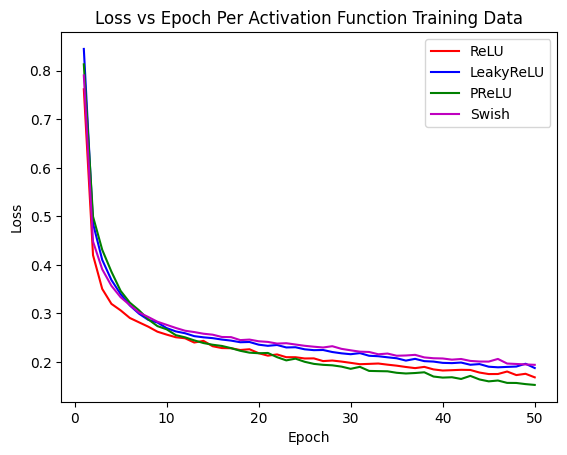

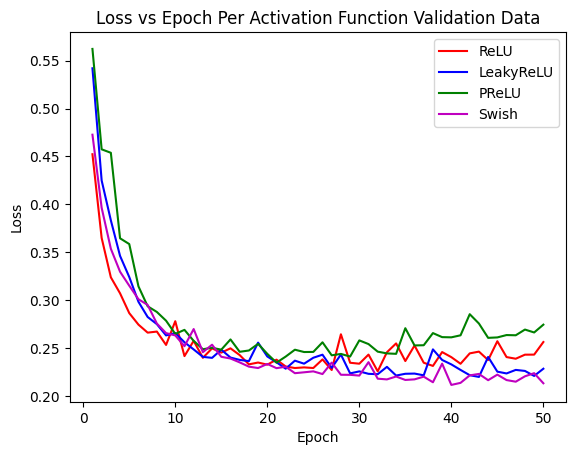

In [ ]:
# Plot losses for each activation function training data

epochs = range(1, len(nn_model_relu_losses) + 1)

plt.plot(epochs, nn_model_relu_losses, 'r', label = 'ReLU')
plt.plot(epochs, nn_model_leakyrelu_losses, 'b', label = 'LeakyReLU')
plt.plot(epochs, nn_model_prelu_losses, 'g', label = 'PReLU')
plt.plot(epochs, nn_model_swish_losses, 'm', label = 'Swish')

plt.title('Loss vs Epoch Per Activation Function Training Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Activation Function Training Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Activation Function Training Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Activation Function Training Data.png', format='png')

plt.show()

# Plot losses for each activation function validation data

epochs = range(1, len(nn_model_relu_losses) + 1)

plt.plot(epochs, nn_model_relu_val_losses, 'r', label = 'ReLU')
plt.plot(epochs, nn_model_leakyrelu_val_losses, 'b', label = 'LeakyReLU')
plt.plot(epochs, nn_model_prelu_val_losses, 'g', label = 'PReLU')
plt.plot(epochs, nn_model_swish_val_losses, 'm', label = 'Swish')

plt.title('Loss vs Epoch Per Activation Function Validation Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Activation Function Validation Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Activation Function Validation Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Loss vs Epoch Per Activation Function Validation Data.png', format='png')

plt.show()


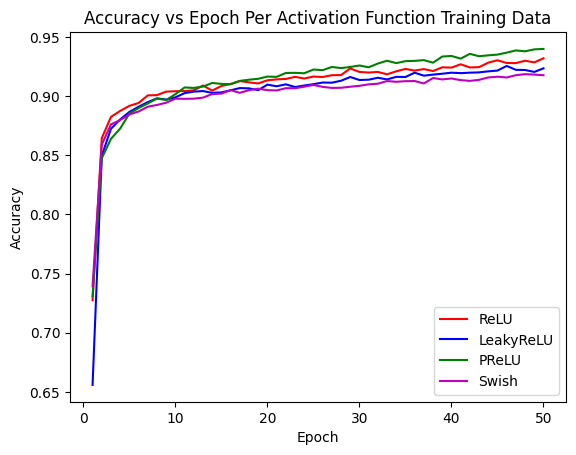

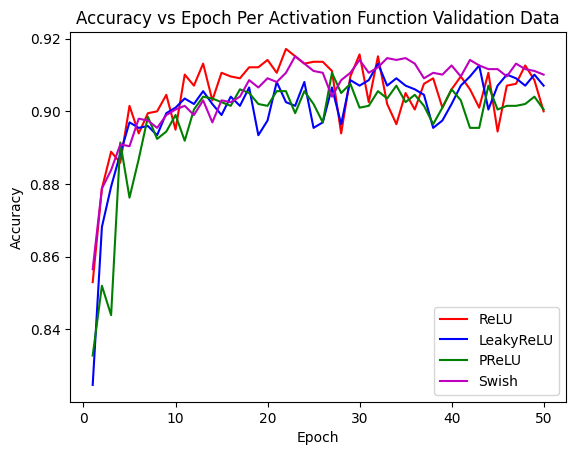

In [ ]:
# Plot accuracy for each activation function validation data

epochs = range(1, len(nn_model_relu_accuracy) + 1)

plt.plot(epochs, nn_model_relu_accuracy, 'r', label = 'ReLU')
plt.plot(epochs, nn_model_leakyrelu_accuracy, 'b', label = 'LeakyReLU')
plt.plot(epochs, nn_model_prelu_accuracy, 'g', label = 'PReLU')
plt.plot(epochs, nn_model_swish_accuracy, 'm', label = 'Swish')

plt.title('Accuracy vs Epoch Per Activation Function Training Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Activation Function Training Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Activation Function Training Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Activation Function Training Data.png')

plt.show()


# Plot accuracy for each activation function validation data

epochs = range(1, len(nn_model_relu_accuracy) + 1)

plt.plot(epochs, nn_model_relu_val_accuracy, 'r', label = 'ReLU')
plt.plot(epochs, nn_model_leakyrelu_val_accuracy, 'b', label = 'LeakyReLU')
plt.plot(epochs, nn_model_prelu_val_accuracy, 'g', label = 'PReLU')
plt.plot(epochs, nn_model_swish_val_accuracy, 'm', label = 'Swish')

plt.title('Accuracy vs Epoch Per Activation Function Validation Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Save plot as png file
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Activation Function Validation Data.png'):
  os.remove('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Activation Function Validation Data.png')

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Plots/Accuracy vs Epoch Per Activation Function Validation Data.png')

plt.show()

